In [22]:
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [23]:
data_folder = r"C:\Users\mehar\OneDrive\Desktop\DLCV\Project"

In [24]:
train_df = pd.read_csv(os.path.join(data_folder, "train.csv"))
test_df = pd.read_csv(os.path.join(data_folder, "test.csv"))
all_image_paths =   {os.path.basename(x): x for x in
                      glob(os.path.join(data_folder, 'images', '*.png'))}
train_df['path'] = train_df['Image Index'].map(all_image_paths.get)
test_df['path'] = test_df['Image Index'].map(all_image_paths.get)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']

In [25]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [26]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

test_gen = core_idg.flow_from_dataframe(dataframe=test_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation

train_X, train_Y = next(core_idg.flow_from_dataframe(dataframe=train_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=test_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 714))
t_x,t_y = next(train_gen)

Found 2835 validated image filenames belonging to 12 classes.
Found 714 validated image filenames belonging to 12 classes.
Found 2835 validated image filenames belonging to 12 classes.
Found 714 validated image filenames belonging to 12 classes.


KeyboardInterrupt: 

In [7]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [8]:
base_inception_resnet_model = InceptionResNetV2(include_top=False,
                                                weights=None,
                                                input_shape=t_x.shape[1:])

# Initialize the model
multi_disease_resnet_model = Sequential()
multi_disease_resnet_model.add(base_inception_resnet_model)
multi_disease_resnet_model.add(GlobalAveragePooling2D())
multi_disease_resnet_model.add(Dropout(0.5))
multi_disease_resnet_model.add(Dense(512, activation='relu'))
multi_disease_resnet_model.add(Dropout(0.5))
multi_disease_resnet_model.add(Dense(len(labels), activation='sigmoid'))  # Multi-label classification

# Compile the model
multi_disease_resnet_model.compile(optimizer=Adam(),
                            loss='binary_crossentropy',
                            metrics=['binary_accuracy', 'mae'])

# Display the model's architecture
multi_disease_resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336160  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                6

In [9]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5.resnet".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]

In [10]:
multi_disease_resnet_model.fit_generator(train_gen, 
                                  steps_per_epoch = 45,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 100, 
                                  callbacks = callbacks_list)

C:\Users\mehar\AppData\Local\Temp\ipykernel_35744\1499390023.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  multi_disease_resnet_model.fit_generator(train_gen,


Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.3976 - binary_accuracy: 0.8635 - mae: 0.2026
Epoch 1: val_loss improved from inf to 0.40939, saving model to xray_class_weights.best.hdf5.resnet
45/45 [==============================] - 37s 454ms/step - loss: 0.3976 - binary_accuracy: 0.8635 - mae: 0.2026 - val_loss: 0.4094 - val_binary_accuracy: 0.8363 - val_mae: 0.2932
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.3433 - binary_accuracy: 0.8797 - mae: 0.1921
Epoch 2: val_loss improved from 0.40939 to 0.33838, saving model to xray_class_weights.best.hdf5.resnet
45/45 [==============================] - 17s 371ms/step - loss: 0.3433 - binary_accuracy: 0.8797 - mae: 0.1921 - val_loss: 0.3384 - val_binary_accuracy: 0.8905 - val_mae: 0.2233
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.3359 - binary_accuracy: 0.8838 - mae: 0.1934
Epoch 3: val_loss improved from 0.33838 to 0.32617, saving model to xray_class_weights.best.

In [27]:
multi_disease_resnet_model.load_weights(weight_path)
pred_Y = multi_disease_resnet_model.predict(test_X, batch_size = 64, verbose = True)

12/12 [==============================] - 1s 78ms/step


In [28]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 14.29%, PDx: 13.13%
Cardiomegaly: Dx: 3.64%, PDx: 2.98%
Consolidation: Dx: 5.88%, PDx: 4.08%
Edema: Dx: 3.22%, PDx: 2.73%
Effusion: Dx: 17.37%, PDx: 21.23%
Emphysema: Dx: 3.22%, PDx: 2.52%
Infiltration: Dx: 26.89%, PDx: 33.89%
Mass: Dx: 7.14%, PDx: 4.60%
No Finding: Dx: 29.27%, PDx: 23.51%
Nodule: Dx: 8.26%, PDx: 6.25%
Pleural_Thickening: Dx: 5.32%, PDx: 4.23%
Pneumothorax: Dx: 6.86%, PDx: 4.27%


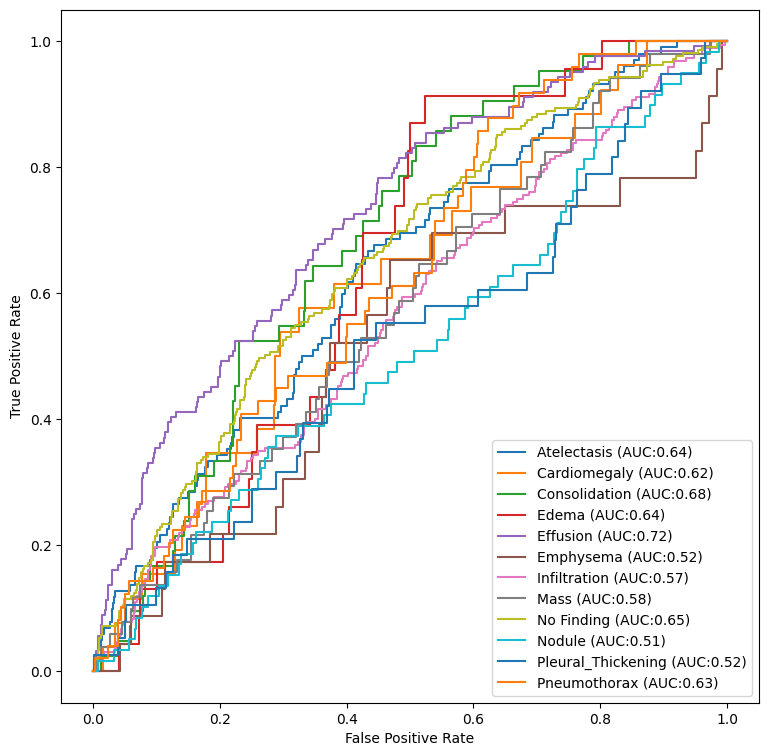

In [29]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

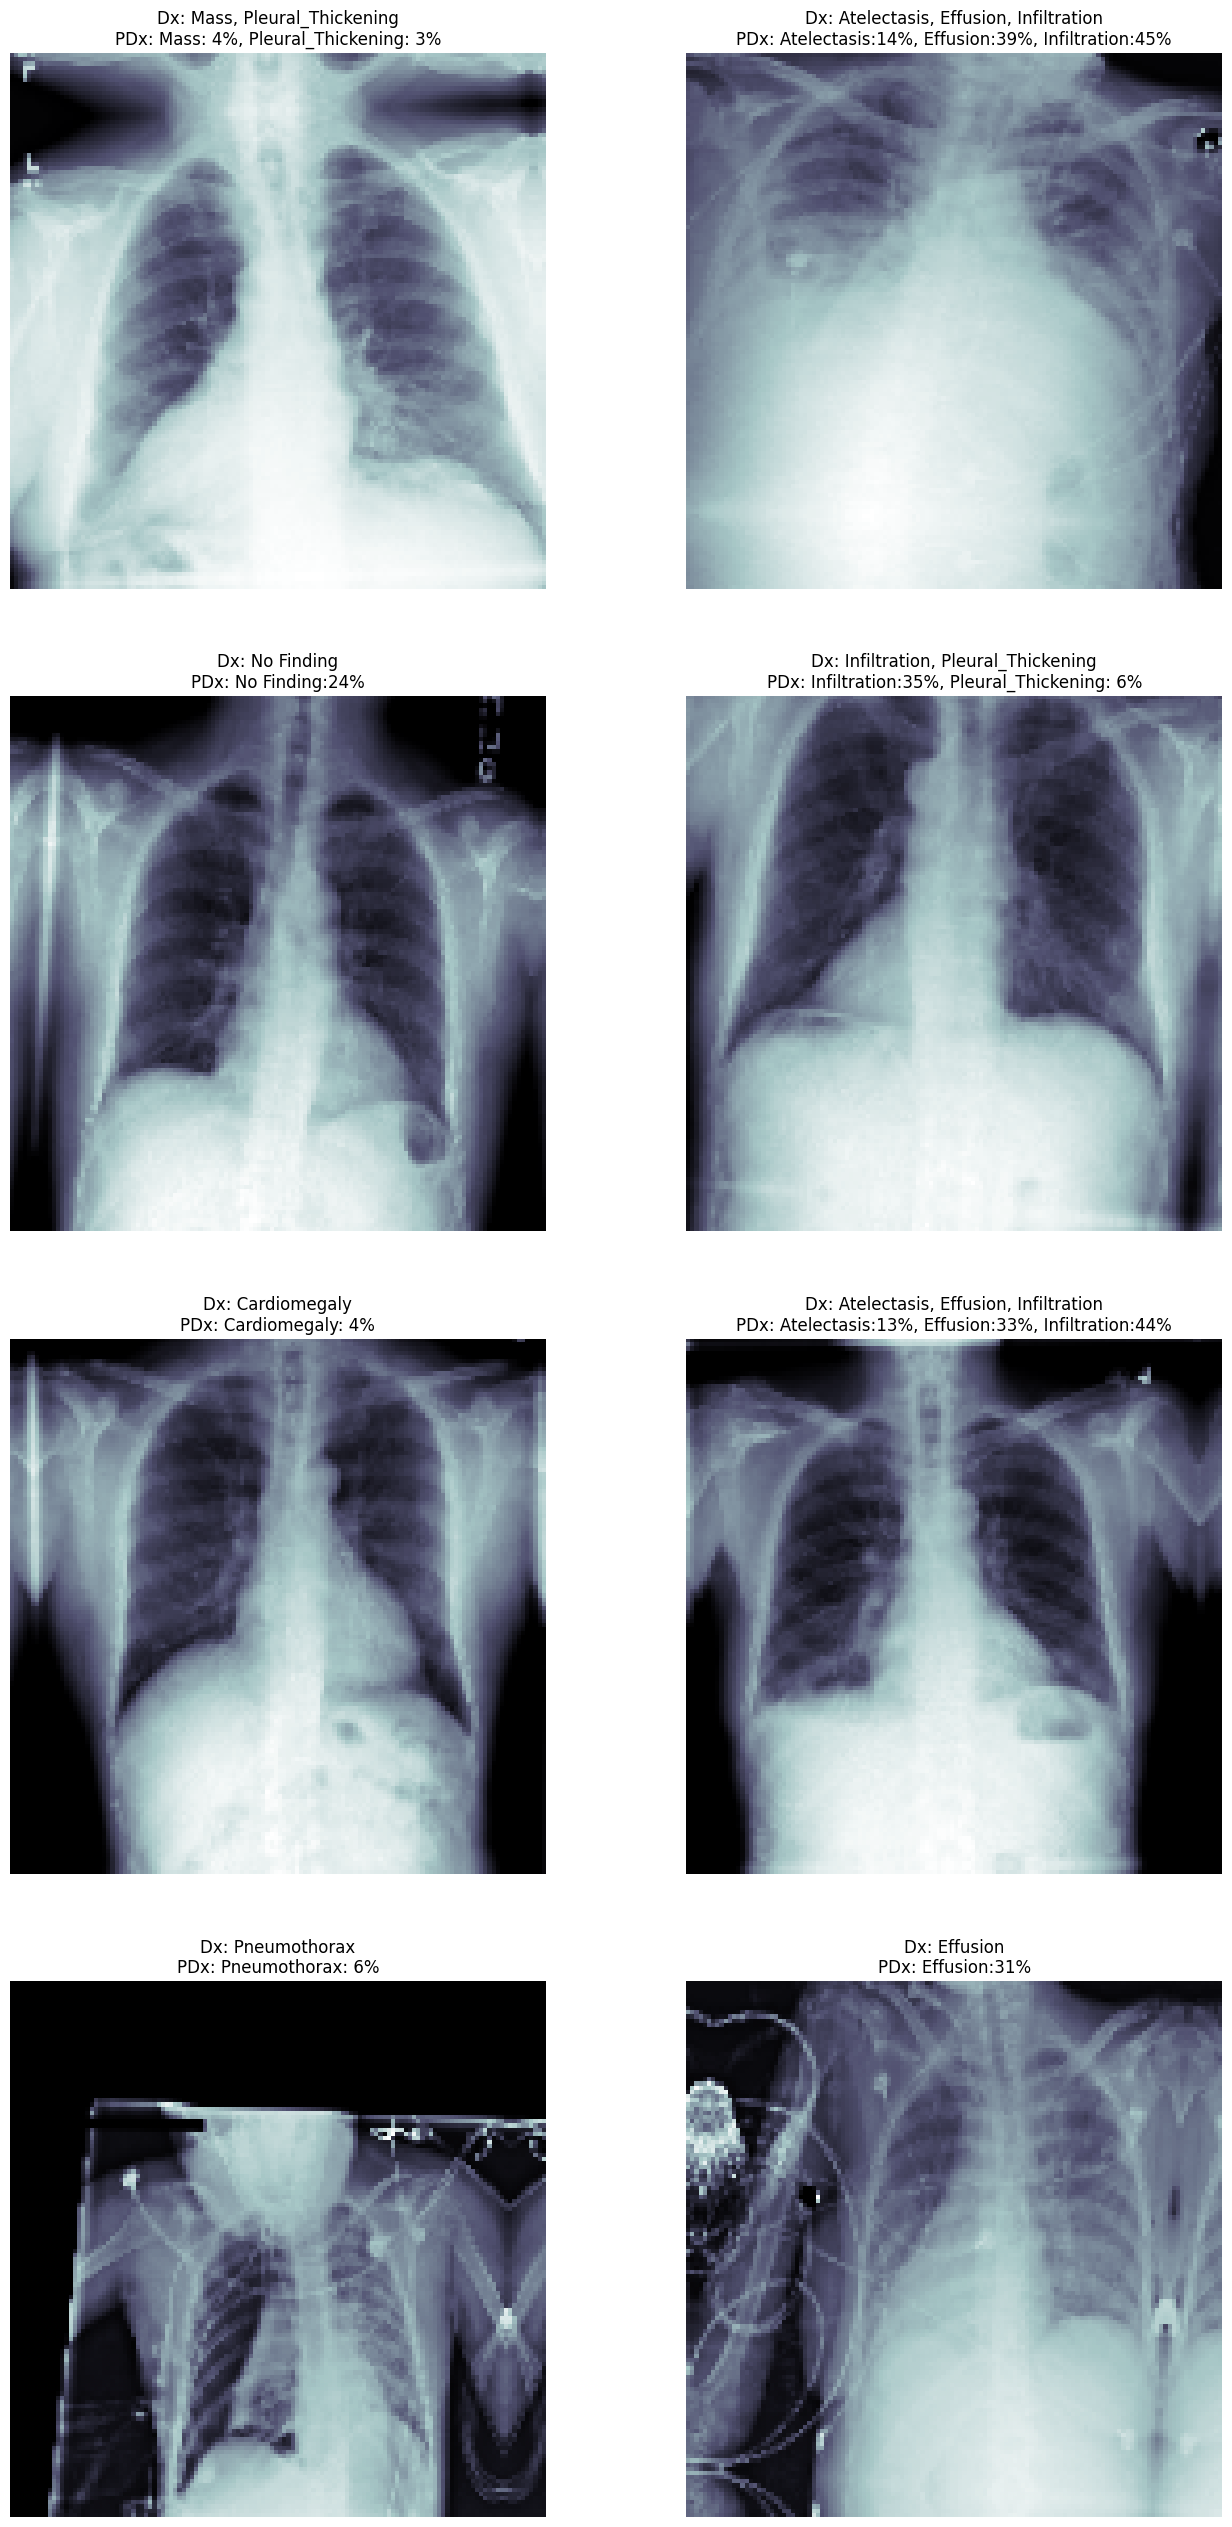

In [30]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class for n_class, n_score in zip(labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class, p_score*100)  for n_class, n_score, p_score in zip(labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions_resnet.png')

In [31]:
test_loss, test_accuracy, test_mae = multi_disease_resnet_model.evaluate(test_X, test_Y)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test MAE: {test_mae}")

23/23 [==============================] - 1s 44ms/step - loss: 0.3059 - binary_accuracy: 0.8910 - mae: 0.1687
Test Loss: 0.3058822453022003, Test Accuracy: 0.8909897804260254, Test MAE: 0.16865862905979156


Testing Resnet model on augmented images

In [32]:
aug_df = pd.read_csv(os.path.join(data_folder, "augmented_image_paths.csv"))
aug_image_paths =   {os.path.basename(x): x for x in
                      glob(os.path.join(data_folder, 'Final Augmented Images', '*.png'))}
aug_df['path'] = aug_df['File name'].map(aug_image_paths.get)
aug_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [33]:
aug_gen = core_idg.flow_from_dataframe(dataframe=aug_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 128) # we can use much larger batches for evaluation

aug_X, aug_Y = next(core_idg.flow_from_dataframe(dataframe=aug_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 294))

Found 294 validated image filenames belonging to 12 classes.
Found 294 validated image filenames belonging to 12 classes.


In [35]:
aug_loss, aug_accuracy, aug_mae = multi_disease_resnet_model.evaluate(aug_X, aug_Y)
print(f"Test Loss: {aug_loss}, Test Accuracy: {aug_accuracy}, Test MAE: {aug_mae}")

10/10 [==============================] - 1s 59ms/step - loss: 0.3449 - binary_accuracy: 0.8835 - mae: 0.1782
Test Loss: 0.34494808316230774, Test Accuracy: 0.8835033774375916, Test MAE: 0.1782098114490509


In [38]:
aug_pred_Y = multi_disease_resnet_model.predict(aug_X, batch_size = 64, verbose = True)

5/5 [==============================] - 1s 119ms/step


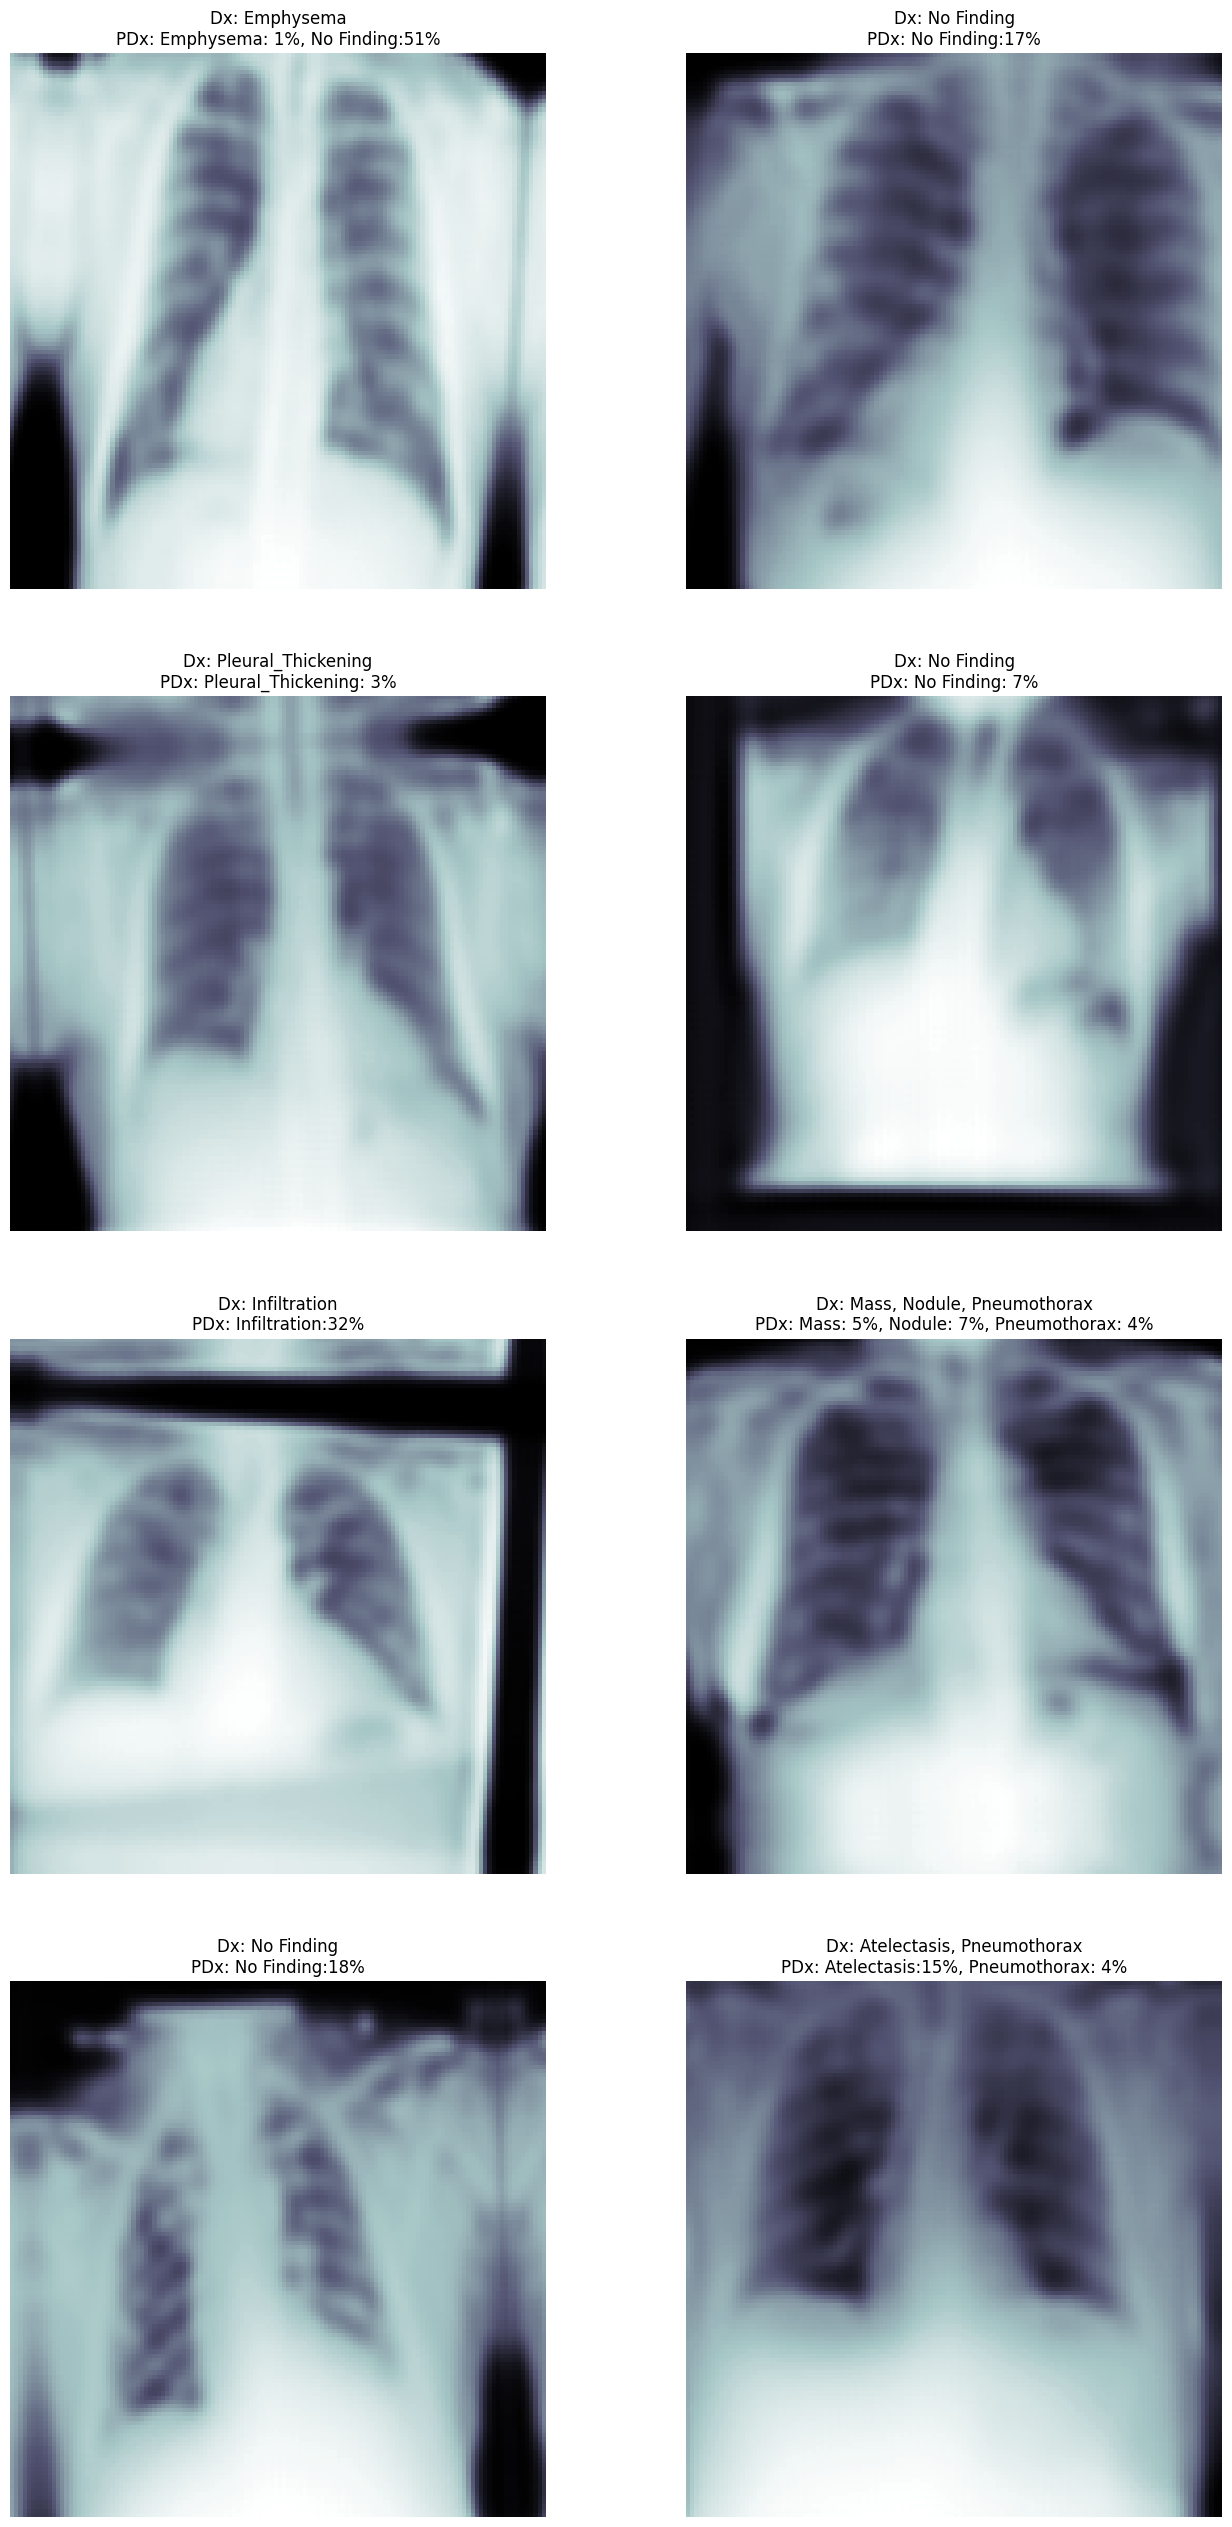

In [39]:
sickest_idx = np.argsort(np.sum(aug_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(aug_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class for n_class, n_score in zip(labels, 
                                                                  aug_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class, p_score*100)  for n_class, n_score, p_score in zip(labels, 
                                                                  aug_Y[idx], aug_pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')